In [81]:
import pandas as pd
import numpy as np
import simulate
import matplotlib.pyplot as plt
import calculate_return as cr
import datetime as dt
import seaborn as sns
import matplotlib
plt.style.use('seaborn')
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=13)  # fontsize of the figure title

#### Import data and prepare returns

In [2]:
df = pd.read_csv('shiller_data.txt', sep="\t", index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index.date)
df['sp_return'] = (df['sp']+df['dividend']).pct_change()

### Loop over every 50 year period starting from january 1871 and calculate returns

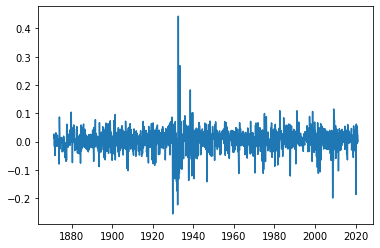

In [3]:
plt.plot(df['sp_return'])
#plt.yscale('log')

In [6]:
final_wealth = []

#for year in range(1871, 1899):
for year in range(1871, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        rf = df.copy().loc[begin:end, 'long_rf'].values/100
        rm = rf.copy() + 0.02
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=rf, YEARLY_RM=rm, YEARLY_INCOME_GROWTH=0.03)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)

[0.00611864 0.00611864 0.00612703 0.00612703 0.00612703 0.00613541
 0.00613541 0.00613541 0.0061438  0.0061438  0.0061438  0.00615218
 0.00615218 0.00616895 0.00618572 0.00620249 0.00621087 0.00622764
 0.00624442 0.00626119 0.00627796 0.00629473 0.00630311 0.00631989
 0.00633666 0.00632827 0.00631989 0.0063115  0.00630311 0.00629473
 0.00629473 0.00628634 0.00627796 0.00626957 0.00626119 0.0062528
 0.00624442 0.00621926 0.00618572 0.00616057 0.00613541 0.00610187
 0.00607672 0.00605157 0.00601804 0.00599289 0.00596774 0.0059342
 0.00590906 0.00587553 0.005842   0.00580847 0.00577494 0.00574142
 0.00570789 0.00567437 0.00564085 0.00560733 0.00557381 0.00554029
 0.00550677 0.00549839 0.00549002 0.00548164 0.00546488 0.0054565
 0.00544812 0.00543974 0.00543136 0.00542298 0.00540623 0.00539785
 0.00538947 0.00538109 0.00537271 0.00536434 0.00535596 0.00534758
 0.00534758 0.0053392  0.00533083 0.00532245 0.00531407 0.00530569
 0.00529731 0.00528894 0.00528056 0.00527218 0.00526381 0.0052554

KeyboardInterrupt: 

In [4]:
shiller_results = pd.DataFrame(final_wealth, columns=['dual_phase', 'single_phase', '100', '9050'],
                              index = pd.date_range('1921-01-01', '2020-12-01', freq='MS'))

NameError: name 'final_wealth' is not defined

Text(0.5, 0, 'Year')

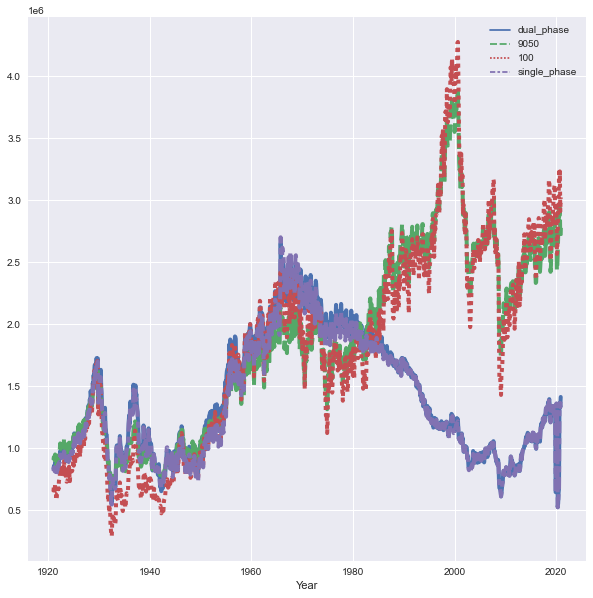

In [126]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(data = shiller_results.loc[:,['dual_phase', '9050', '100', 'single_phase']], linewidth = 4, linestyle="solid")      # Levered investments
ax.set_xlabel('Year')


## Pi development

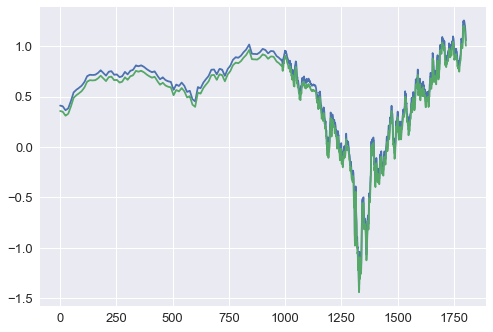

In [57]:
rf = df.loc[:, 'long_rf'].values/100
rm = rf +0.003
plt.plot(cr.calc_pi(2, 0.0278, 0.076, rf))
plt.plot(cr.calc_pi(2, 0.0278, 0.076, rm))

In [58]:
var = (df['sp']+df['dividend']).asfreq('Y', method='bfill').pct_change().var()
mr = (df['sp']+df['dividend']).asfreq('Y', method='bfill').pct_change().mean()

In [62]:
rf.mean()

0.04515016629711751

In [67]:
cr.pi_arr(rf.mean(), 2, var, mr, 0.002)

0.2182255621925663

### 30-year pi development

In [95]:
import pandas as pd
import numpy as np
import simulate
import matplotlib.pyplot as plt
import calculate_return as cr
import datetime as dt
import seaborn as sns
import math

In [109]:
roll_df = df.rolling(12*30).mean().dropna()
#roll_std = (df['sp_return']).rolling(12*30).var().dropna()
roll_std = (df['sp']+df['dividend']).pct_change().rolling(12*30).std().dropna()*math.sqrt(12)**2
roll_sp_return = np.exp(roll_df['sp_return']*12)-1
roll_rf = roll_df['long_rf']/100
roll_rm = roll_rf.copy()+0.003

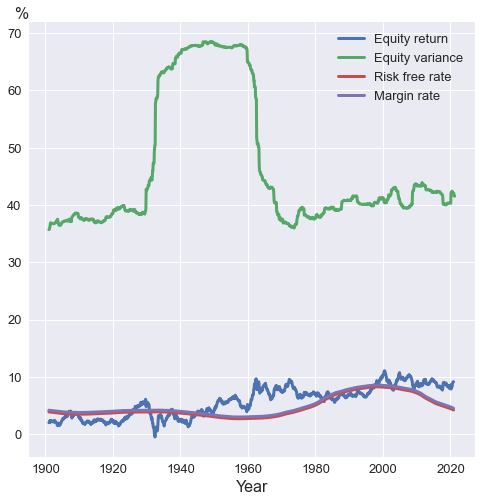

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(roll_sp_return*100, linewidth = 3)
ax.plot(roll_std*100, linewidth = 3)
ax.plot(roll_rf*100, linewidth = 3)
ax.plot(roll_rm*100, linewidth = 3)
#ax.legend(['Equity return', 'Equity standard deviation', 'Risk free rate', 'Margin rate'])
ax.legend(['Equity return', 'Equity variance', 'Risk free rate', 'Margin rate'])
ax.set_xlabel('Year')
ax.set_ylabel('%', rotation=0, loc='top', labelpad=-21)
fig.savefig('Empirical/rolling_development.png', bbox_inches = 'tight', pad_inches = 0.1)

### Resulting pi

Text(0, 1, '%')

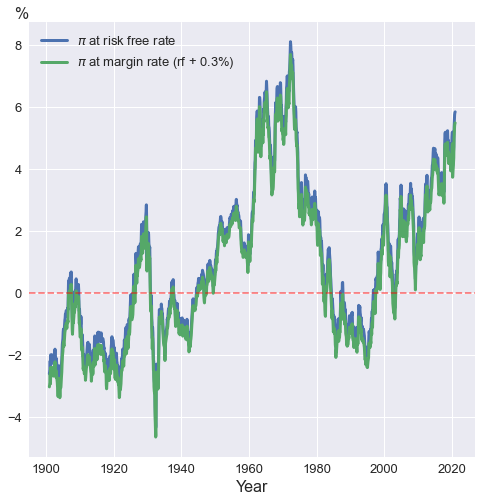

In [116]:
combined_rf = zip(roll_rf, roll_sp_return, roll_std)
pi_rf = [cr.pi_arr(rf, 2, std, ret, 0)*100 for rf, ret, std in combined_rf]

combined_rm = zip(roll_rm, roll_sp_return, roll_std)
pi_rm = [cr.pi_arr(rm, 2, std, ret, 0)*100 for rm, ret, std in combined_rm]

pies = pd.DataFrame([pi_rf, pi_rm]).transpose()
pies.index = pd.date_range('1901-01-01', '2020-12-01', freq='MS')
pies.columns = ['pi_rf', 'pi_rm']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(pies, linewidth = 3)
ax.axhline(0, c='red', alpha=.5, linestyle='--')
ax.legend(['$\pi$ at risk free rate', '$\pi$ at margin rate (rf + 0.3%)'])
ax.set_xlabel('Year')
ax.set_ylabel('%', rotation=0, loc='top', labelpad=-21)
#fig.savefig('Empirical/rolling_pi.png', bbox_inches = 'tight', pad_inches = 0.1)

### Using constant $\pi_{rf}$ and $\pi_{rm}$ to test strategy

In [68]:
final_wealth = []

#for year in range(1871, 1899):
for year in range(1901, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        #rf = roll_rf.copy().loc[begin]
        #std = roll_std.copy().loc[begin]
        #mr = roll_sp_return.copy().loc[begin]
        #YEARLY_RF = np.full(len(returns), rf)
        #YEARLY_RM = YEARLY_RF + 0.02
        YEARLY_RF = roll_rf.copy().loc[begin:end].values
        YEARLY_RM = YEARLY_RF + 0.003
        
        #pi_rf_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        #pi_rm_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        pi_rm_shiller = np.full(601, 0.166)
        pi_rf_shiller = np.full(601, 0.218)
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=YEARLY_RF, YEARLY_RM=YEARLY_RF, YEARLY_INCOME_GROWTH=0.03, 
                                                 MR = mr, PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)

In [69]:
shiller_results = pd.DataFrame(final_wealth, columns=['dual_phase', 'single_phase', '100', '9050'],
                              index = pd.date_range('1951-01-01', '2020-12-01', freq='MS'))
#cpi_norm = df.cpi/df.cpi.iloc[960]
#shiller_results = shiller_results.div(cpi_norm.loc['1951-01-01': '2020-12-01'], axis = 0)

Text(0, 1, 'DKK million')

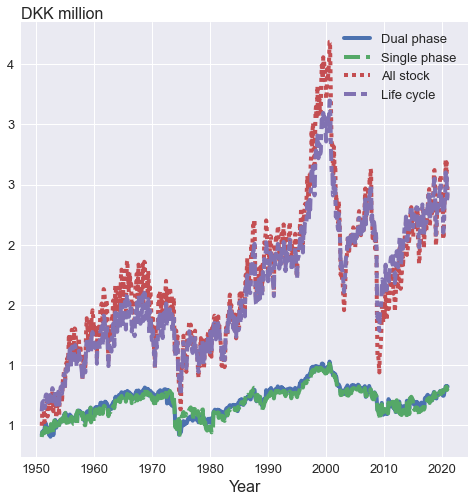

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(data = shiller_results.loc[:,['dual_phase', 'single_phase', '100', '9050']]/1000000, linewidth = 4, linestyle="solid")      # Levered investments
ax.legend(['Dual phase', 'Single phase', 'All stock', 'Life cycle'])
ax.set_xlabel('Ending year')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('DKK million', rotation=0, loc='top', labelpad=-96)

### Using rolling $\pi_{rf}$ and $\pi_{rm}$ to test strategy

In [ ]:
final_wealth = []

#for year in range(1871, 1899):
for year in range(1901, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        #rf = roll_rf.copy().loc[begin]
        std = roll_std.copy().loc[begin]
        #mr = roll_sp_return.copy().loc[begin]
        #YEARLY_RF = np.full(len(returns), rf)
        #YEARLY_RM = YEARLY_RF + 0.02
        YEARLY_RF = roll_rf.copy().loc[begin:end].values
        YEARLY_RM = YEARLY_RF + 0.003
        
        pi_rf_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        pi_rm_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        pi_rm_shiller = np.full(601, 0.166)
        pi_rf_shiller = np.full(601, 0.218)
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=YEARLY_RF, YEARLY_RM=YEARLY_RF, YEARLY_INCOME_GROWTH=0.03, 
                                                 MR = mr, PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)